In [ ]:
pip install sentinelhub --upgrade

In [1]:
# here you can place default parameters which will be overwritten by the 
# actual parameters in a new cell below
spatial_res = 0.00072
aoi = "POLYGON ((11.519165 41.786673, 11.519165 42.259016, 12.420044 42.259016, 12.420044 41.786673, 11.519165 41.786673))"
time_range= "2022-02-15/2022-03-14"


In [2]:
# Configure logging to stderr such that messages appear in notebook
# NOTE: Logging messages from python files which are called from the notebook 
#       will then also appear in the notebook.
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
)

In [3]:
from pathlib import Path

# This is a fixed path you can use to write the output file to.
# The data written here will end up in a unique location for every job run.
output_dir = Path("/home/jovyan/result-data")

In [4]:
import shapely.wkt

# aoi is passed as WKT, need bbox
polygon = shapely.wkt.loads(aoi)
bbox = polygon.bounds
bbox

(11.519165, 41.786673, 12.420044, 42.259016)

In [5]:
from datetime import date, timedelta
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
import xcube.core.maskset as maskset
import xarray as xr

# time range conversion

x = time_range.split("/")

# calculate the number of days based on input parameters

from datetime import datetime
date_format = "%Y-%m-%d"
start_date = datetime.strptime(x[0], date_format)
end_date = datetime.strptime(x[1], date_format)

# credentials from your EDC account are automatically available as environment variables
# which are then used by xcube_sh
creds = CubeConfig

creds

cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B08', 'SCL'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=[(start_date), (end_date)])

ndvi_cube = open_cube(cube_config)

# print basic information here to help with debugging
ndvi_cube

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:148: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


<xarray.Dataset>
Dimensions:    (time: 10, lat: 656, lon: 1536, bnds: 2)
Coordinates:
  * lat        (lat) float64 42.26 42.26 42.26 42.26 ... 41.79 41.79 41.79 41.79
  * lon        (lon) float64 11.52 11.52 11.52 11.52 ... 12.62 12.62 12.62 12.62
  * time       (time) datetime64[ns] 2022-02-17T10:19:10 ... 2022-03-11T10:09:09
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(10, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 656, 512), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 656, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 656, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-03-16T10:09:00.428761
    time_coverage_start:     2022-02-17T10:19:09+00:00
    time_coverage_end:       2022-03-11T10:09:13+00:00
    time_coverage_duration:  P21DT23H50M4S
    geospatial_lon_min:      11.519165
    geospatial_lat_min:      41.786673
    geospatial_lon_max:      12.625084999999999
    geospatial_lat_max:      42.258993000000004
    processing_level:        L2A

In [6]:
# Define NDVI in visualisation
ndvi = ((ndvi_cube.B08-ndvi_cube.B04)/(ndvi_cube.B08+ndvi_cube.B04))

ndvi.attrs['long_name']='NDVI'
ndvi.attrs['units']='unitless'

ndvi_cube['NDVI']= ndvi  

In [7]:
ndvi_sum = ndvi_cube.NDVI.sum(dim="time")
ndvi_count = ndvi_cube.NDVI.count(dim="time")
ndvi_average = ndvi_sum / ndvi_count

ndvi_average.attrs['long_name']='ndvi_average'
ndvi_average.attrs['units']='nounits'

ndvi_cube['ndvi_average']= ndvi_average

In [8]:
result = ndvi_average
logging.info("size: %s", result.size)

2022-01-12 15:02:52,060 [INFO] root - size: 1007616


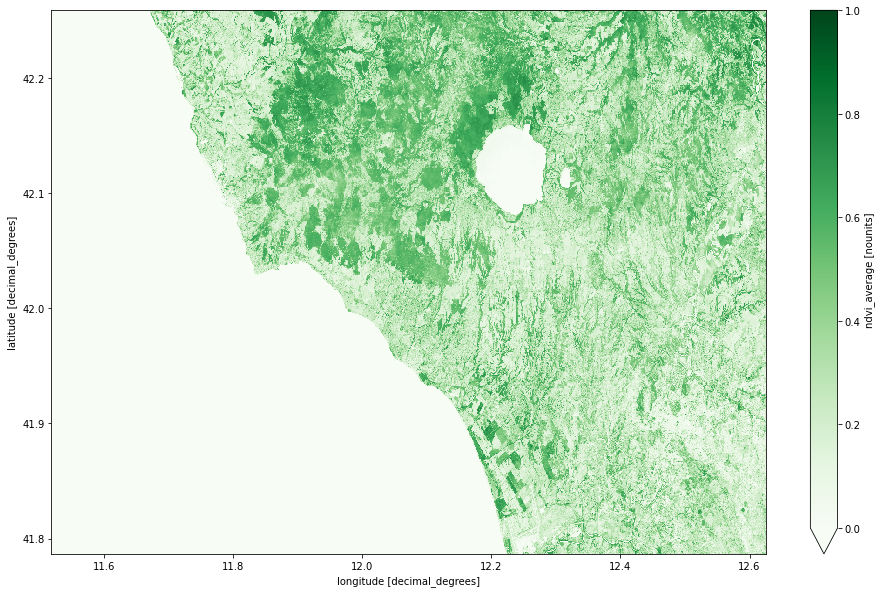

In [9]:
%matplotlib inline
import IPython.display
result.plot.imshow(vmin=0, vmax=1, cmap='Greens', figsize=(16, 10))

In [10]:
filename = time_range[0] + "_to_" + time_range[1] + "_mean_ndvi.tif"
result.rio.to_raster(output_dir / filename, dtype="float32")
logging.info("file %s written", filename)

2022-01-12 15:04:59,202 [INFO] root - file 2021-06-01_to_2021-08-31_mean_ndvi.tif written
